# Trabalho de análise de dados da matéria do professor Laio
-----
Aluno: Leonardo José
Tema: Análise de fuga de corrente devido a deposicao de sal em insuladores em alto mar
O presente trabalho utiliza a combinacao de arquiteturas Seq2Seq e LSTM fornecidas pelo professor, com a adicao de estrutura "atention" para auxiliar a rede a focar em elementos relevante sna hora do treinamento. O uso de rede Seq2Seq + LSTM se deve ao fato dos dados terem relacao temporal entre eles, com um input "rolante" de uma sequencia e um output de uma sequencia de dados que serao a previsao da corrente nos insuladores.

Link Empirical Wavelets: https://pypi.org/project/ewtpy/

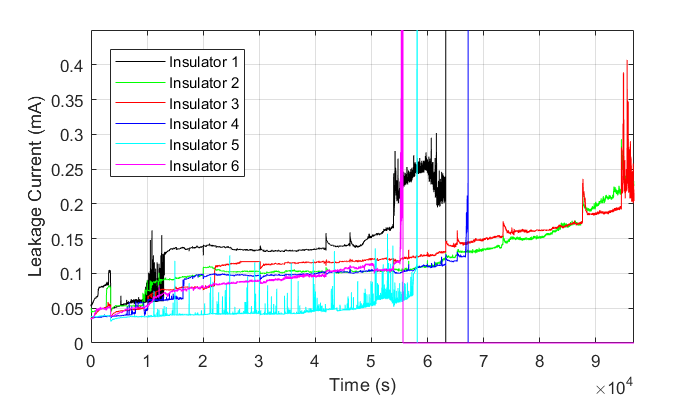

#### Obtencao dos dados:

             Insulador 1  Insulador 2  Insulador 3  Insulador 4  Insulador 5  \
Insulador 1     1.000000    -0.531576    -0.440451     0.796962     0.664670   
Insulador 2    -0.531576     1.000000     0.947203    -0.559488    -0.627594   
Insulador 3    -0.440451     0.947203     1.000000    -0.446580    -0.587499   
Insulador 4     0.796962    -0.559488    -0.446580     1.000000     0.607351   
Insulador 5     0.664670    -0.627594    -0.587499     0.607351     1.000000   
Insulador 6     0.471816    -0.427254    -0.388799     0.488188     0.585946   

             Insulador 6  
Insulador 1     0.471816  
Insulador 2    -0.427254  
Insulador 3    -0.388799  
Insulador 4     0.488188  
Insulador 5     0.585946  
Insulador 6     1.000000  
interval columns not set, guessing: ['Insulador 1', 'Insulador 2', 'Insulador 3', 'Insulador 4', 'Insulador 5', 'Insulador 6']


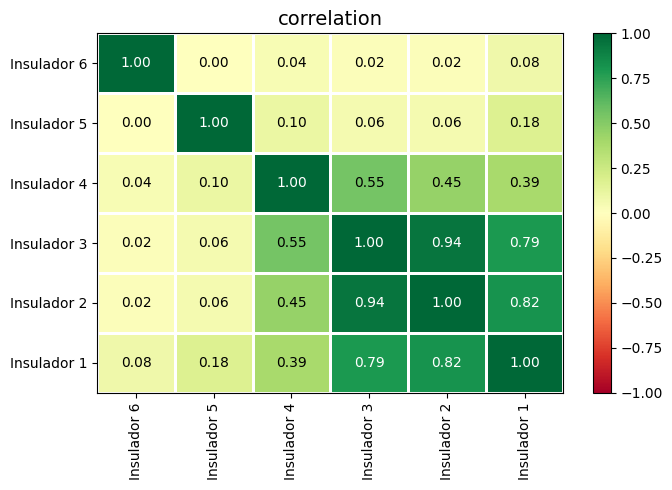

In [27]:
import pandas as pd

# Bibliotecas para ver a correlacao do tipo Phi-K (Nao só linear)
from phik import resources
from phik.report import plot_correlation_matrix
from phik import phik_matrix

# Pegar os dados dos insuladores do arquivo excel com pandas
file_path = 'BaseDados.xlsx'
col_insulators = [9, 10, 11, 12, 13, 14]
insulators_df = pd.read_excel(file_path, usecols=col_insulators)
new_column_names = [f'Insulador {i+1}' for i in range(len(col_insulators))]
insulators_df.columns = new_column_names

# Calcular a matriz de correlação de Pearson
correlation_df = insulators_df.corr(method='pearson')
print(correlation_df)

# Calcular a matriz de correlação Phik
phik_corr_matrix = insulators_df.phik_matrix()
plot_correlation_matrix(phik_corr_matrix.values, x_labels=phik_corr_matrix.columns, y_labels=phik_corr_matrix.index)



### Dados obtidos com a correlacao
1. Verificou-se que existe uma forte correlacao entre o insulador 2 e 3 tanto com Pearson, quanto Phi-K.
2. Verificou-se uma forte correlacao entre o insulador 4 e 1, utilzando Pearson.
3. Verificou-se uma forte correlacao entre o insulador 2 e 3 com 1, utilizando Phi-K

### Convertendo os arrays de dados dos insuladores de dataframes para tensores
Nessa etapa os dados sao convertidos para tensor, sao removidos os zeros no final dos arrays para nao treinar a rede com dados que nao existem e é divido cada insulador na metade, uma parte para teste e uma parte para treinamento.

In [29]:
import torch

insulator_tensors = []

for num_insulator in range(len(col_insulators)):
    insulator_column = insulators_df.iloc[:, num_insulator]
    insulator_numpy = insulator_column.to_numpy()
    insulator_tensor = torch.tensor(insulator_numpy, dtype=torch.float32)
    
    # Tirar os zeros no final do array de dados
    non_zero_indices = torch.nonzero(insulator_tensor).squeeze(-1)
    last_non_zero_idx = non_zero_indices[-1].item()
    insulator_tensor = insulator_tensor[:last_non_zero_idx + 1]
    insulator_tensors.append(insulator_tensor)
    
    print("Tensor referente ao insulador: ", num_insulator + 1)
    print("Tamanho tensor de treinamento: ", insulator_tensor.shape[0], " leituras.")
    print("Tensor:", insulator_tensor, "\n")

Tensor referente ao insulador:  1
Tamanho tensor de treinamento:  63246  leituras.
Tensor: tensor([0.0540, 0.0550, 0.0540,  ..., 0.2150, 0.2030, 1.0000]) 

Tensor referente ao insulador:  2
Tamanho tensor de treinamento:  96816  leituras.
Tensor: tensor([0.0490, 0.0500, 0.0500,  ..., 0.2270, 0.2270, 0.2260]) 

Tensor referente ao insulador:  3
Tamanho tensor de treinamento:  96816  leituras.
Tensor: tensor([0.0350, 0.0360, 0.0350,  ..., 0.2090, 0.2040, 0.2060]) 

Tensor referente ao insulador:  4
Tamanho tensor de treinamento:  67248  leituras.
Tensor: tensor([0.0350, 0.0350, 0.0350,  ..., 0.2470, 0.2310, 1.0000]) 

Tensor referente ao insulador:  5
Tamanho tensor de treinamento:  58177  leituras.
Tensor: tensor([0.0380, 0.0380, 0.0380,  ..., 0.3750, 0.4140, 1.0000]) 

Tensor referente ao insulador:  6
Tamanho tensor de treinamento:  55633  leituras.
Tensor: tensor([0.0350, 0.0350, 0.0350,  ..., 0.1980, 0.1990, 1.0000]) 



### Tentando simplificar os sinais temporais em sub-sinais temporais
Wavelet Empírica, apresenta um melhor resultado para análise e pode-se escolher a quantidade de sub-sinais.

Sinal reconstruído: tensor([-0.0095, -0.0095, -0.0095,  ..., -0.0330, -0.0330, -0.0330],
       dtype=torch.float64)


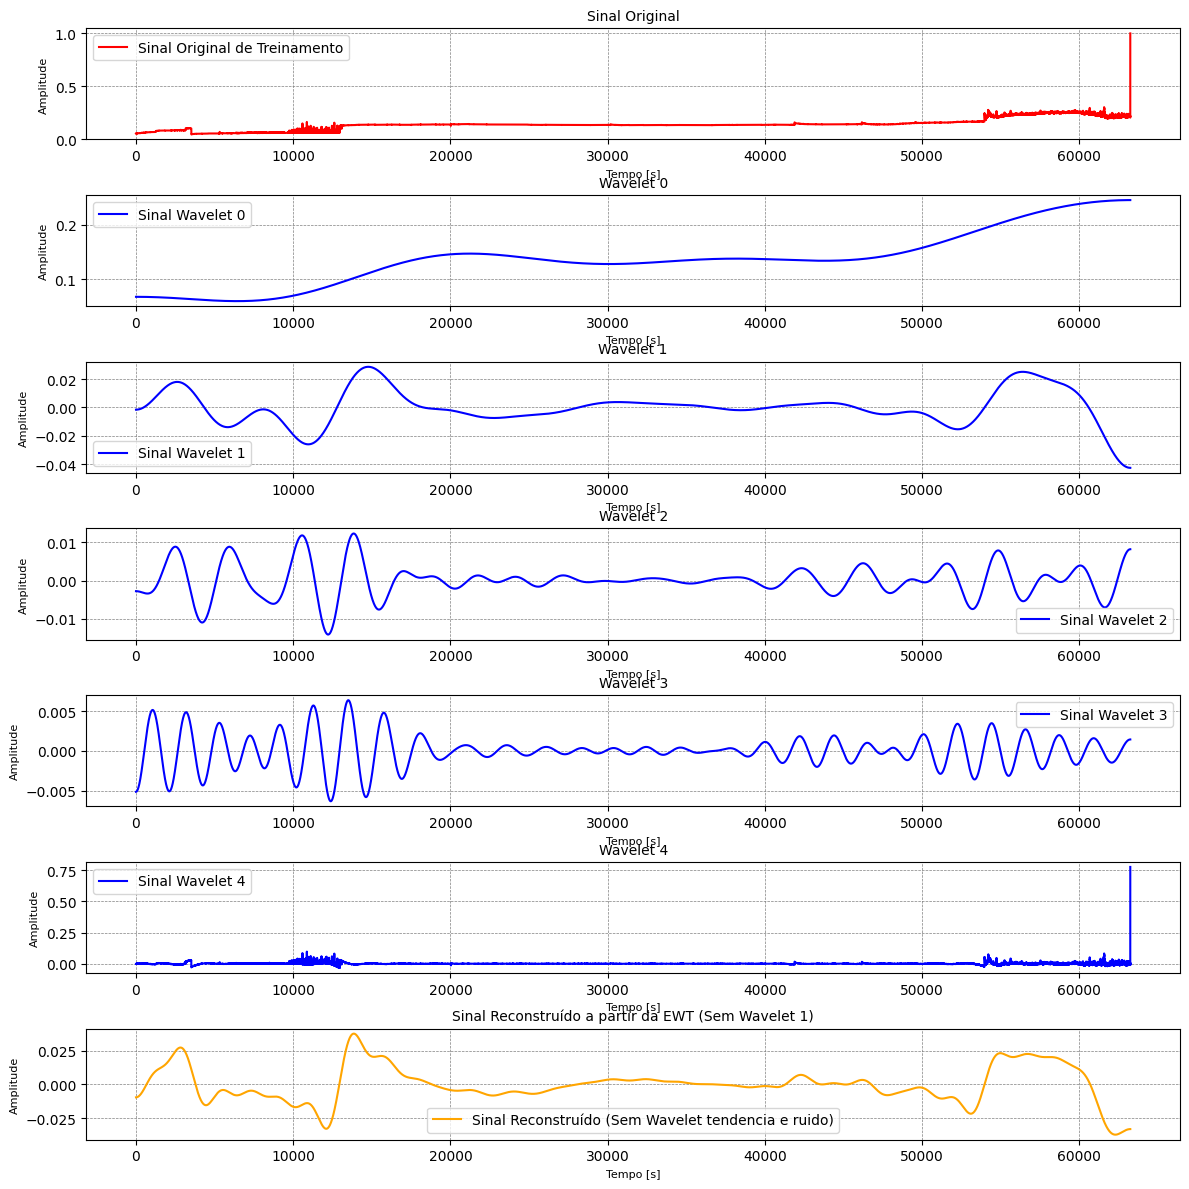

Sinal reconstruído: tensor([-0.0056, -0.0056, -0.0056,  ...,  0.0080,  0.0080,  0.0080],
       dtype=torch.float64)


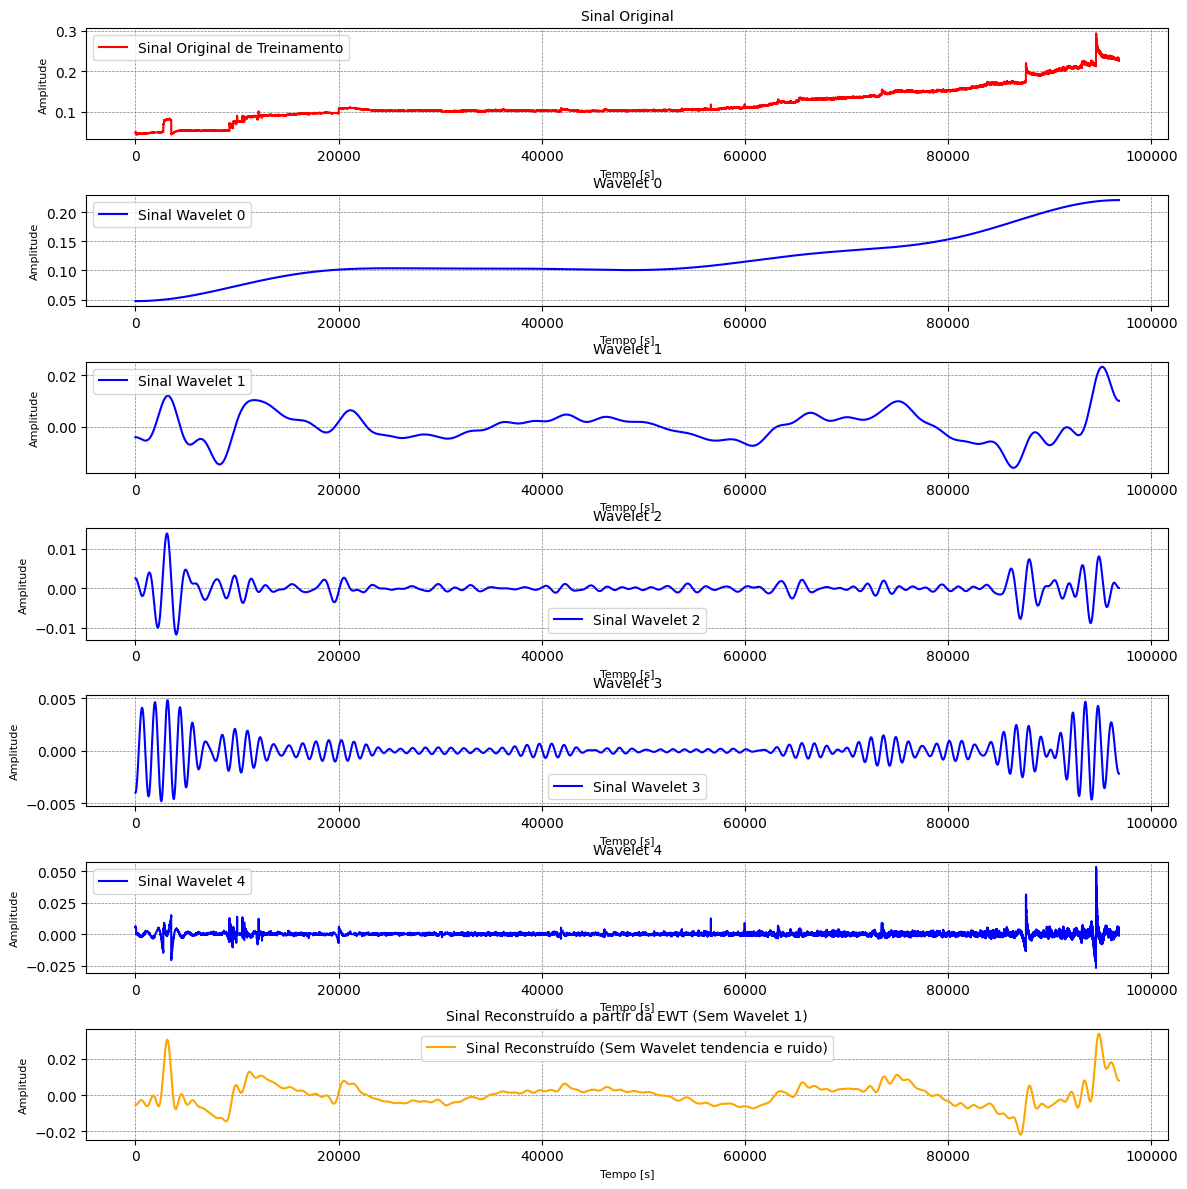

Sinal reconstruído: tensor([-0.0083, -0.0083, -0.0083,  ...,  0.0154,  0.0154,  0.0154],
       dtype=torch.float64)


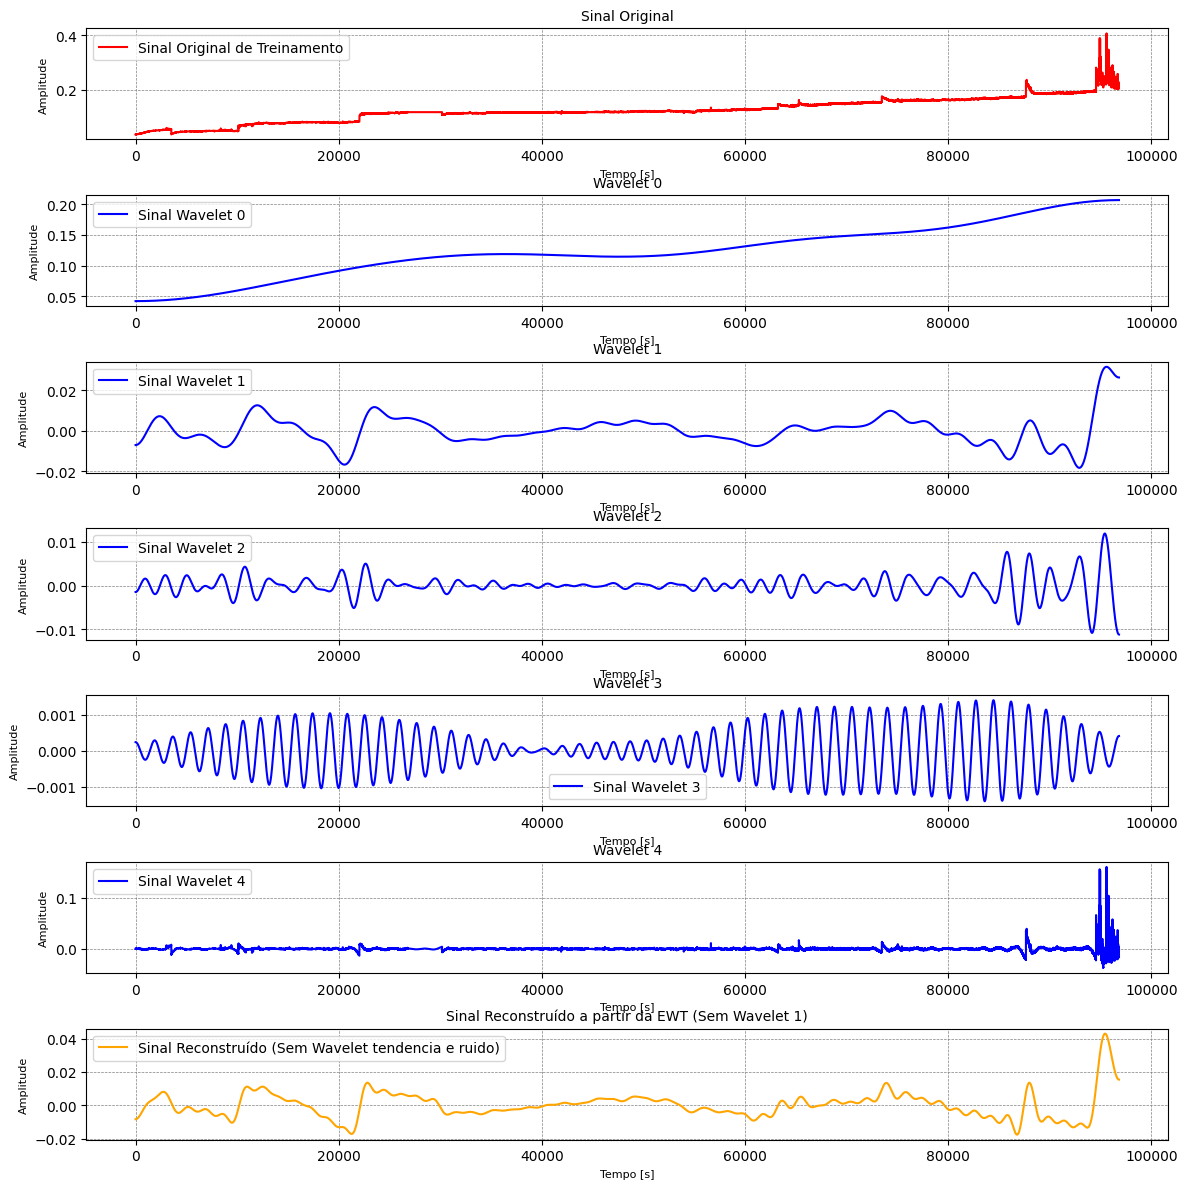

Sinal reconstruído: tensor([-0.0011, -0.0011, -0.0011,  ...,  0.0331,  0.0331,  0.0331],
       dtype=torch.float64)


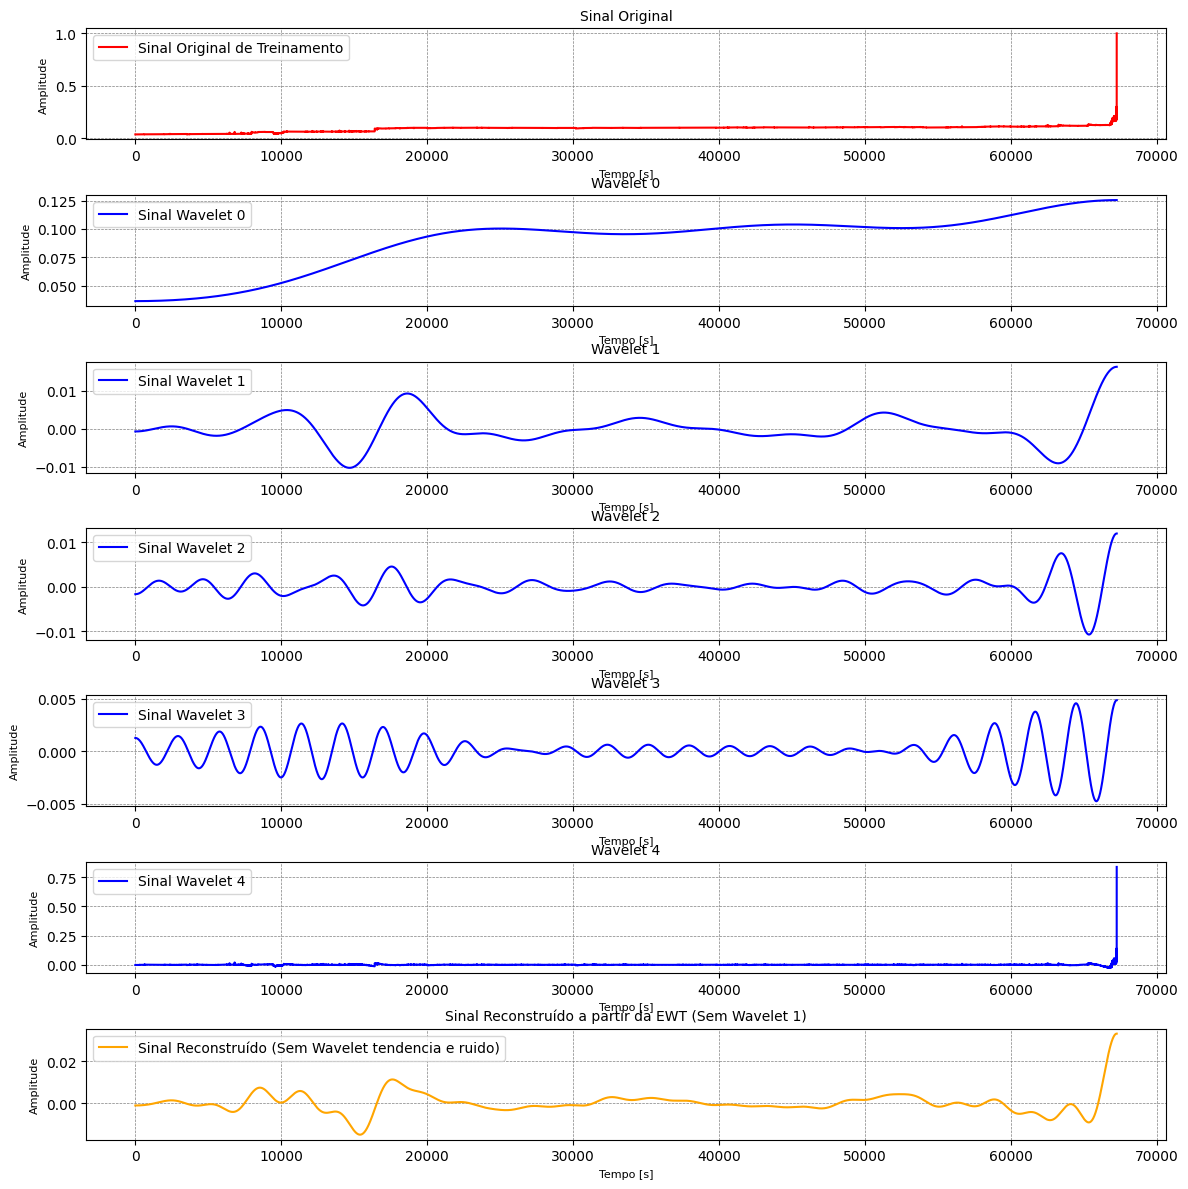

Sinal reconstruído: tensor([-0.0003, -0.0003, -0.0003,  ...,  0.1700,  0.1700,  0.1700],
       dtype=torch.float64)


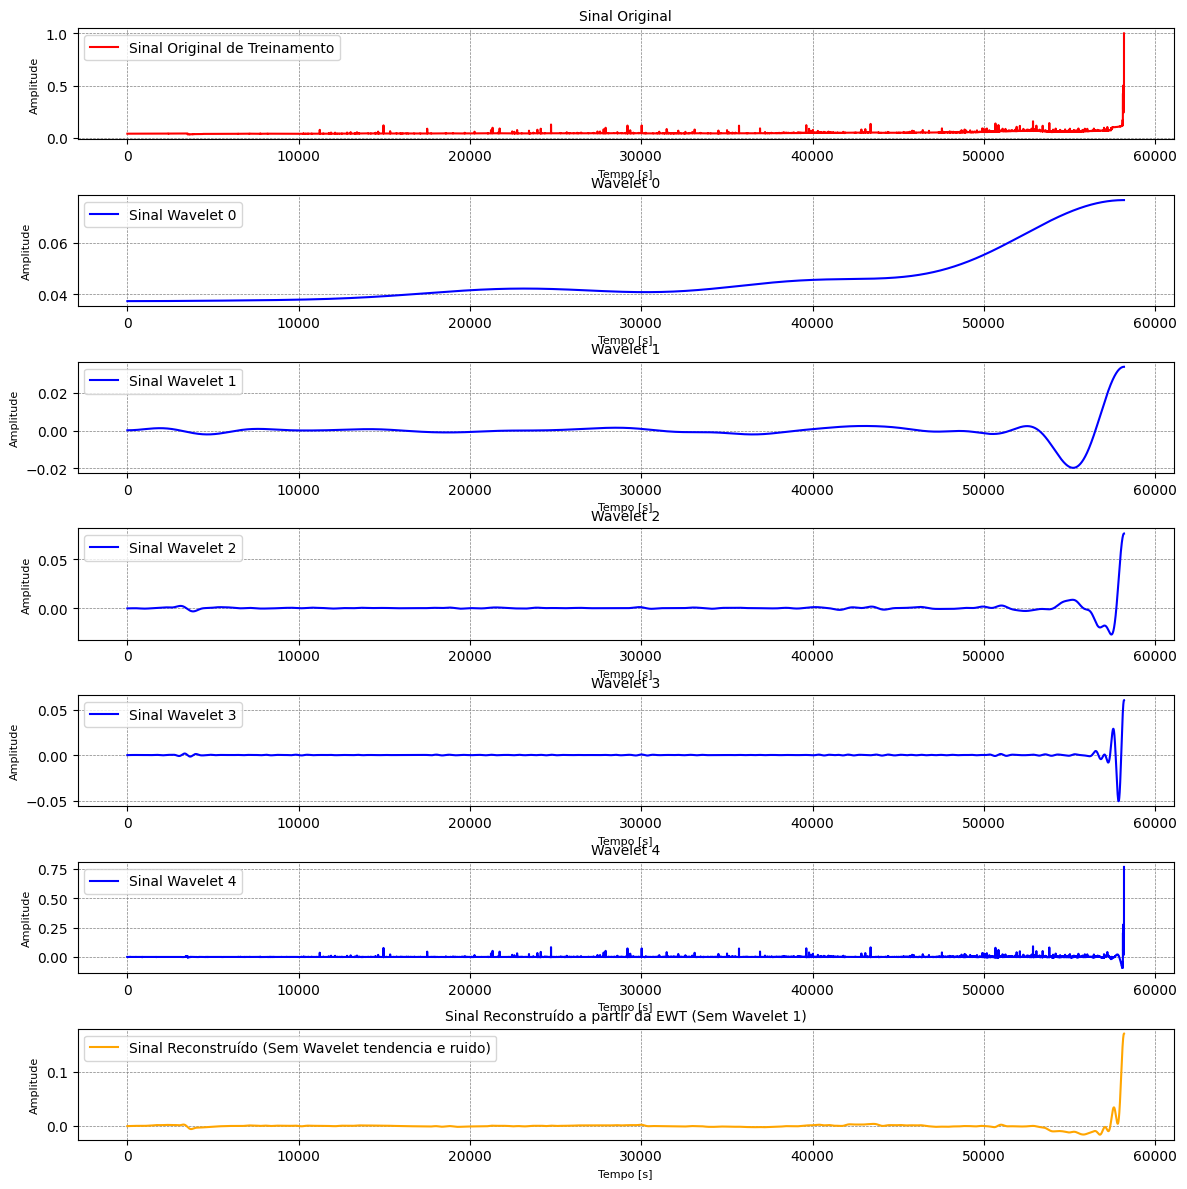

Sinal reconstruído: tensor([-0.0109, -0.0109, -0.0109,  ...,  0.3249,  0.3249,  0.3249],
       dtype=torch.float64)


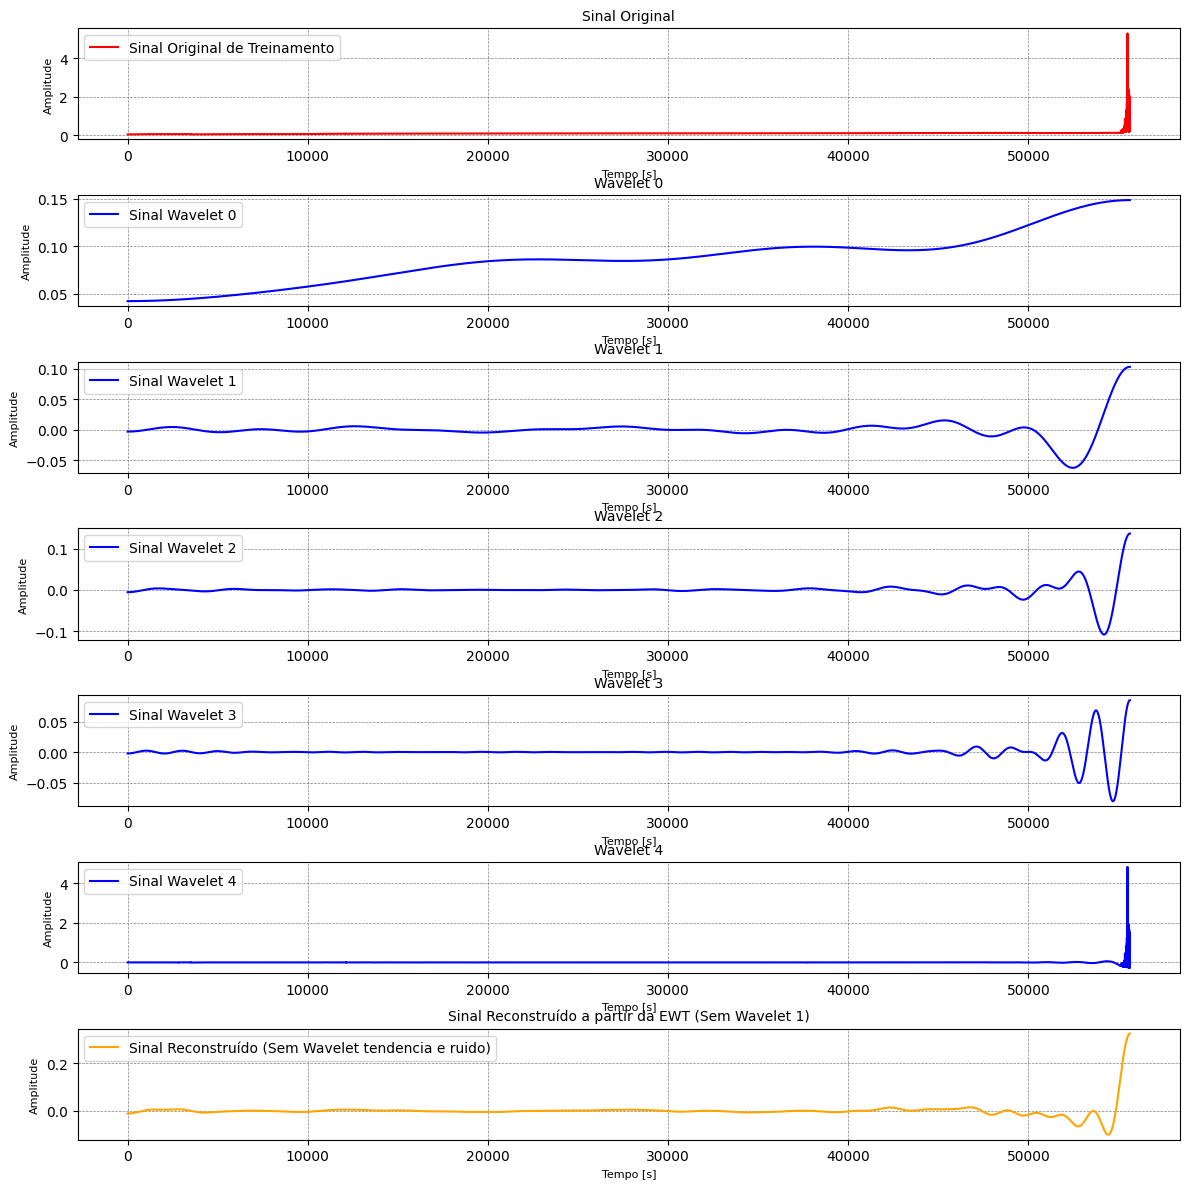

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import ewtpy

new_data_array = []
for insulator_tensor in insulator_tensors:
    # Número de wavelets
    num_wavelets = 5

    insulator_data = insulator_tensor
    t = np.arange(0, len(insulator_data)) 
    insulator_data_numpy = insulator_data.numpy()

    # Aplicar a Wavelet Empírica
    ewt, mfb, boundaries = ewtpy.EWT1D(insulator_data_numpy, N=num_wavelets)
    reconstructed_signal = np.sum(ewt, axis=1)

    plt.figure(figsize=(12, 12))

    # Plotar o sinal original
    plt.subplot(2 + num_wavelets, 1, 1)
    plt.plot(t, insulator_data_numpy, label='Sinal Original de Treinamento', color='red')
    plt.title('Sinal Original',fontsize=10)
    plt.xlabel('Tempo [s]',fontsize=8)
    plt.ylabel('Amplitude',fontsize=8)
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.legend()

    # Plotar o sinal de cada wavelet
    for wavelet in range(num_wavelets):
        plt.subplot(2 + num_wavelets, 1, wavelet + 2)
        plt.plot(t, ewt[:, wavelet], label=f'Sinal Wavelet {wavelet}', color='blue')
        plt.title(f'Wavelet {wavelet}',fontsize=10)
        plt.xlabel('Tempo [s]',fontsize=8)
        plt.ylabel('Amplitude',fontsize=8)
        plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
        plt.legend()

    # Remover a primeira wavelet
    ewt_last_wavelets = np.delete(ewt, [0,num_wavelets-1], axis=1)
    reconstructed_wavelet_filtered = np.sum(ewt_last_wavelets, axis=1)
    new_train_data = torch.from_numpy(reconstructed_wavelet_filtered)
    new_data_array.append(new_train_data)
    print("Sinal reconstruído: {}".format(new_train_data))

    # Plotar o sinal reconstruído sem Wavelet tendencia e ruido
    plt.subplot(2 + num_wavelets, 1, num_wavelets + 2)
    plt.plot(t, reconstructed_wavelet_filtered, label='Sinal Reconstruído (Sem Wavelet tendencia e ruido)', color='orange')
    plt.title('Sinal Reconstruído a partir da EWT (Sem Wavelet 1)',fontsize=10)
    plt.xlabel('Tempo [s]',fontsize=8)
    plt.ylabel('Amplitude',fontsize=8) 
    plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()


### Rede neural do professor Seq2Seq/LSTM, com a arquitetura atention.

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Verifica GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Função para processar os dados
def process_data(tensor_data, seq_len=50):
    train_size = int(0.5 * tensor_data.size(0))  # Adjust split ratio if needed
    data = [tensor_data[i:i+seq_len] for i in range(tensor_data.size(0) - seq_len)]
    data = torch.stack(data).unsqueeze(-1).float()  # Add extra dimension

    X_train, X_test = data[:train_size], data[train_size:]
    return X_train.to(device), X_test.to(device)

# Camada de Atenção simplificada
# Camada de Atenção corrigida
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # Camada para calcular energia
        self.v = nn.Parameter(torch.rand(hidden_size))  # Vetor de pesos

    def forward(self, hidden, encoder_outputs):
        # hidden: [1, batch_size, hidden_size]
        # encoder_outputs: [seq_len, batch_size, hidden_size]
        
        seq_len = encoder_outputs.size(0)
        batch_size = encoder_outputs.size(1)

        # Repetir hidden para o número de steps da sequência
        hidden = hidden.repeat(seq_len, 1, 1)  # [seq_len, batch_size, hidden_size]
        
        # Concatenar hidden e encoder_outputs
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # [seq_len, batch_size, hidden_size]
        
        # Calcula a atenção
        energy = energy.permute(1, 0, 2)  # [batch_size, seq_len, hidden_size]
        
        # Expande v para ter o batch_size e seq_len corretos para multiplicação
        v_expanded = self.v.unsqueeze(0).unsqueeze(0).expand(batch_size, -1, -1)  # [batch_size, 1, hidden_size]
        
        # Multiplicação com o vetor de atenção v
        attention_weights = torch.bmm(v_expanded, energy.permute(0, 2, 1)).squeeze(1)  # [batch_size, seq_len]
        
        return torch.softmax(attention_weights, dim=1)



# Decoder com Atenção
class DecoderWithAttention(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderWithAttention, self).__init__()
        self.lstm = nn.LSTM(output_size, hidden_size)  # Camada LSTM
        self.fc_out = nn.Linear(hidden_size, output_size)  # Camada final
        self.attention = Attention(hidden_size)  # Instância de atenção

    def forward(self, input_seq, hidden, cell, encoder_outputs):
        attn_weights = self.attention(hidden, encoder_outputs)  # Calcula pesos de atenção
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs.permute(1, 0, 2))
        output, (hidden, cell) = self.lstm(input_seq, (hidden, cell))  # Passo normal LSTM
        output = output + attn_applied.permute(1, 0, 2)  # Combina com atenção aplicada
        prediction = self.fc_out(output)  # Predição
        return prediction, hidden, cell

# Encoder simplificado
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input_seq):
        return self.lstm(input_seq)  # Retorna todos os outputs do encoder

# Modelo Seq2Seq com Atenção
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_seq, target_seq_len, teacher_forcing_ratio=0.5):
        batch_size, output_size = source_seq.shape[1], self.decoder.fc_out.out_features
        outputs = torch.zeros(target_seq_len, batch_size, output_size).to(source_seq.device)
        encoder_outputs, (hidden, cell) = self.encoder(source_seq)
        decoder_input = torch.zeros(1, batch_size, output_size).to(source_seq.device)

        for t in range(target_seq_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell, encoder_outputs)
            outputs[t] = output
            decoder_input = output if np.random.random() > teacher_forcing_ratio else source_seq[t].unsqueeze(0)

        return outputs

# Treinamento
def train_seq2seq(model, X_train, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train.permute(1, 0, 2), X_train.shape[1])
        loss = criterion(outputs, X_train.permute(1, 0, 2))
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# Avaliação e plotagem
def evaluate_seq2seq(model, X_test, start_idx=0, end_idx=50):
  model.eval()
  with torch.no_grad():
    predictions = model(X_test.permute(1, 0, 2), X_test.shape[1], teacher_forcing_ratio=0.0).permute(1, 0, 2).cpu().numpy()
    X_test = X_test.cpu().numpy()

    # Plotar um intervalo específico da sequência
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[start_idx:end_idx, 0, 0], label="Sequência Real", color='green')
    plt.plot(predictions[start_idx:end_idx, 0, 0], label="Sequência Predita", linestyle=":", color='red')

    print("Sequencia de treino: ", X_test[start_idx:end_idx, 0, 0])

    plt.title("Real vs Predito")
    plt.legend()
    plt.show()

# Execução
if __name__ == "__main__":
    # Dados fictícios
    X_train, X_test = process_data(new_data_array[1])
    print("Formato dado de treinamento: ",X_train.shape)
    print("Formato dado de teste: ",X_test.shape)

    # Inicializa o modelo
    hidden_size = 6
    encoder = Encoder(1, hidden_size).to(device)
    decoder = DecoderWithAttention(hidden_size, 1).to(device)
    seq2seq_model = Seq2SeqWithAttention(encoder, decoder).to(device)

    # Treina o modelo
    train_seq2seq(seq2seq_model, X_train, epochs=100, learning_rate=0.005)

Usando dispositivo: cpu
Formato dado de treinamento:  torch.Size([48408, 50, 1])
Formato dado de teste:  torch.Size([48358, 50, 1])


KeyboardInterrupt: 

Sequencia de treino:  [ 0.00305605  0.00305705  0.00305807 ... -0.03304629 -0.03304525
 -0.03304424]


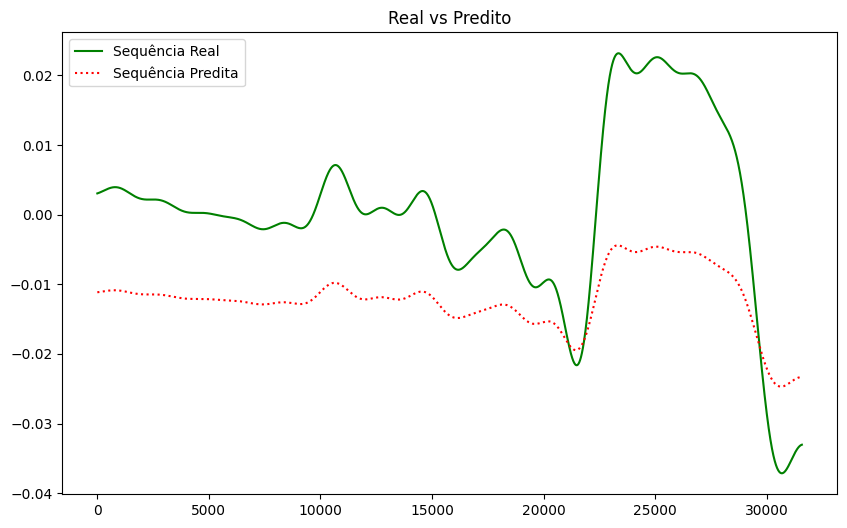

In [24]:
# Avalia e plota
evaluate_seq2seq(seq2seq_model, X_test, start_idx=0, end_idx=31573)  # Plotar do índice 10 ao 60